In [1]:
import torch
import torchvision
from mmpose.apis.inference import init_model, init_default_scope
from matplotlib import pyplot as plt
from mmengine import Config

ckpt = '../resources/vitpose/td-hm_ViTPose-small_8xb64-210e_coco-256x192-62d7a712_20230314.pth'
cfg = '../resources/vitpose/td-hm_ViTPose-small_8xb64-210e_coco-256x192.py'
device = 'cuda:1'
image = '../resources/test_image.png'

cfg = Config.fromfile(cfg)
init_default_scope('mmpose')
model = init_model(cfg, ckpt, device=device)

std = torch.tensor(cfg.model.data_preprocessor.std)
mean = torch.tensor(cfg.model.data_preprocessor.mean)

Loads checkpoint by local backend from path: ../resources/vitpose/td-hm_ViTPose-small_8xb64-210e_coco-256x192-62d7a712_20230314.pth


data type: uint8


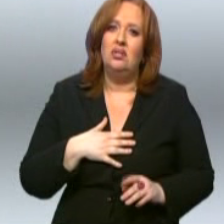

In [11]:
#prepare data
from PIL import Image
import numpy as np

def central_crop(image, crop_width, crop_height):
    # Get the dimensions of the image
    img_width, img_height = image.size

    # Calculate the coordinates for the central crop
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = (img_width + crop_width) / 2
    bottom = (img_height + crop_height) / 2

    # Perform the crop
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

image = Image.open('../resources/test_image.png')
image = central_crop(image, 224, 224)
print(f'data type: {np.array(image).dtype}')
image

In [12]:
#preprocess the data
import einops
data = torch.from_numpy(np.array(image)).float()
data = (data - std) / mean
print(f'std: {data.std()}, mean: {data.mean()}')

data = einops.rearrange(data, '(n h) w c -> n c h w', n=1).to(device)
print(f'data shape {data.shape}')

std: 0.6731945276260376, mean: 0.4586787223815918
data shape torch.Size([1, 3, 224, 224])


In [39]:
with torch.no_grad():
    a = model(data, None, 'tensor')
print(f'output size: {a.shape}')
a = torch.max(a, 1, keepdim=True).values
print(f'shape after max: {a.shape}')
a = torch.nn.functional.interpolate(a, (224, 224))
a = torch.squeeze(a, dim=(0, 1))
a.shape

output size: torch.Size([1, 17, 56, 56])
shape after max: torch.Size([1, 1, 56, 56])


torch.Size([224, 224])

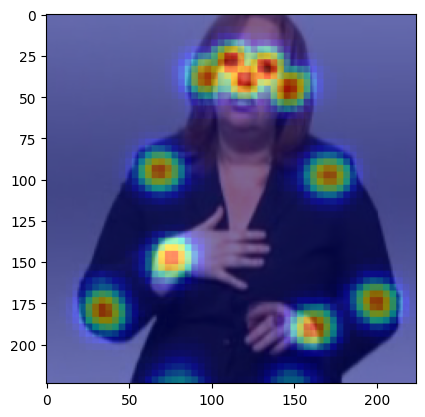

In [42]:
def apply_colormap(heatmap):
    """Apply a colormap to the heatmap and normalize."""
    cmap = plt.get_cmap('jet')
    heatmap_colored = cmap(heatmap)  # Apply colormap
    return heatmap_colored[..., :3]  # Discard alpha channel

def blend_images(base_img, overlay_img, alpha=0.5):
    """Blend the base image with the overlay image."""
    return (1 - alpha) * base_img + alpha * overlay_img

origin = np.array(image, dtype='float32')/255.0
heatmap = apply_colormap(a.cpu().numpy())
blend_image = blend_images(origin, heatmap, alpha=0.5)
plt.imshow(blend_image)